In [1]:
import numpy as np

from itertools import product

import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

from tracks import fancytrack, fancytrack2

In [42]:
from tempfile import NamedTemporaryFile
from IPython.display import HTML

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=10, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

# automatically display animations
animation.Animation._repr_html_ = anim_to_html

In [3]:
class Track(object):
    def __init__(self, track):
        """
            0 = off track
            1 = road - on track
            2 = start line
            3 = finish line
        """
        self.track = track

    def get_next_position(self, racecar):
        """
            RaceCar racecar: RaceCar object
        """
        
        reward = -1
        crash = False
        
        new_x = racecar.x + racecar.velocity_x
        new_y = racecar.y + racecar.velocity_y
        
        final_x = new_x
        final_y = new_y
        
        # Compute all the unique boxes we hit on a line between the start and end points
        x_positions = np.linspace(racecar.x, new_x, num=20)
        y_positions = np.linspace(racecar.y, new_y, num=20)
        positions = zip(x_positions, y_positions)
        positions = [(np.floor(x), np.floor(y)) for x, y in positions]
        
        # Get unique discrete positions visited during this time step
        ordered_positions = []
        for pos in positions:
            if len(ordered_positions) == 0 or pos != ordered_positions[-1]:
                ordered_positions.append(pos)
                        
        # Check if the car crashes into the track at any of those time points
        #   or if it reached the finish line
        for pos_idx, pos in enumerate(ordered_positions):

            # ability to speed past the finish without penalty
            if self.is_terminal_state_from_coordinates(pos[0], pos[1]):
                reward = -1
                final_x, final_y = ordered_positions[pos_idx]
                break
            
            # check if the car crashes
            if self.is_out_of_bounds(pos):
                reward -= 5
                crash_x, crash_y = pos
                final_x, final_y = ordered_positions[pos_idx - 1]
                racecar.velocity_x = 0
                racecar.velocity_y = 0
                crash = True
                break
            

        # If the car is not moving, the car must move at least 1 step
        # But Here instead, we just give a negative reward for not moving, since we have left turns as well
        if final_x == racecar.x and final_y == racecar.y:
            reward -= 5

        racecar.x = final_x
        racecar.y = final_y
        
        return reward, crash

    def convert_cartesian_to_indexes(self, x, y):
        y_prime, x_prime = x, y
        x_prime = self.track.shape[0] - x_prime - 1
        return int(x_prime), int(y_prime)
    
    def convert_indexes_to_cartesian(self, x, y):
        y_prime, x_prime = x, y
        y_prime = self.track.shape[0] - y_prime - 1
        return int(x_prime), int(y_prime)
    
    def is_terminal_state(self, racecar):
        x, y = self.convert_cartesian_to_indexes(racecar.x, racecar.y)
        if self.track[x, y] == 3:
            return True
        return False
    
    def is_terminal_state_from_coordinates(self, x, y):
        if self.is_out_of_bounds((x, y)):
            return False

        x, y = self.convert_cartesian_to_indexes(x, y)
        if self.track[x, y] == 3:
            return True
        return False
    
    def is_out_of_bounds(self, position):
        x, y = position
        
        if x < 0 or x >= self.track.shape[1]:
            return True
        
        if y < 0 or y >= self.track.shape[0]:
            return True

        # y is reversed in our frame of reference
        x, y = self.convert_cartesian_to_indexes(x, y)

        if self.track[x, y] == 0:
            return True
        
        return False
    
    def get_random_start(self):
        # returns x and y coordinates of random start
        starts = np.argwhere(self.track == 2)
        random_start = np.random.randint(len(starts))
        start = starts[random_start]
        return self.convert_indexes_to_cartesian(*start)
    
    def get_states(self):
        return [self.convert_indexes_to_cartesian(x, y) for x, y in np.argwhere(self.track != 0)]
    
    def print_track(self, x, y):
        x, y = self.convert_cartesian_to_indexes(x, y)
        pt = np.copy(self.track)
        pt[x, y] = -1
        print(pt)
        
    

In [4]:
class RaceCar(object):
    def __init__(self):
        self.velocity_x = 0
        self.velocity_y = 0
        self.x = 0
        self.y = 0
        
        self.MAX_VELOCITY = 5
        self.MIN_VELOCITY = -5

    def get_episode(self, pi, track, actions, states, greedy=False, verbose=False, max_episodes=200):
        """
            actions: an index to action dictionary
            pi: numpy array of probabilities to take an action given the state
        
        """

        self.velocity_x = 0; self.velocity_y = 0
        self.x, self.y = track.get_random_start()

        saved_actions = []
        crash_events = [False]
        rewards = [0]
        visited_states = [((self.x, self.y), (self.velocity_x, self.velocity_y))]
        visited_positions = set([(self.x, self.y)])
        
        terminated = False
        while not terminated:
            state_idx = states[((self.x, self.y), (self.velocity_x, self.velocity_y))]

            # choose greedy action with probability pi
            if greedy:
                action_idx = np.where(pi[state_idx, :] == np.amax(pi[state_idx, :]))[0]
                action_idx = np.random.choice(action_idx)   
            else:
                action_idx = np.random.choice(len(actions), size=1, p=pi[state_idx, :])[0]    
            
            action = actions[action_idx]
            saved_actions.append(action)
            
            # Take the action
            self.velocity_x += action[0]
            self.velocity_y += action[1]
            self.velocity_x = min(max(self.velocity_x, self.MIN_VELOCITY), self.MAX_VELOCITY)
            self.velocity_y = min(max(self.velocity_y, self.MIN_VELOCITY), self.MAX_VELOCITY)

            # check if the car crashed, didn't move, or if we should end the episode, and penalize the rewards
            reward, crash = track.get_next_position(self)
            if (self.x, self.y) in visited_positions:
                reward -= 6
                # pass
            if len(visited_states) > max_episodes:
                terminated = True
            else:
                terminated = track.is_terminal_state(self)
            
            # save the rewards, states, and actions
            crash_events.append(crash)
            rewards.append(reward)
            visited_states.append(((self.x, self.y), (self.velocity_x, self.velocity_y)))
            visited_positions.update([(self.x, self.y)])
            if terminated: saved_actions.append((0,0))
            
            if verbose:
                track.print_track(self.x, self.y)
                print('Velocity is now: ', (self.velocity_x, self.velocity_y))
        
        return visited_states, saved_actions, rewards, crash_events
        
    def get_states(self):
        return list(product(
                range(self.MIN_VELOCITY, self.MAX_VELOCITY + 1),
                range(self.MIN_VELOCITY, self.MAX_VELOCITY + 1)
            )
        )

In [46]:
class MonteCarlo(object):
    def __init__(self, actions, agent, environment):
        self.actions_list = actions
        self.agent = agent
        self.environment = environment
        
        self.actions_to_idx = {action: idx for idx, action in enumerate(self.actions_list)}
        self.idx_to_actions = {idx: action for idx, action in enumerate(self.actions_list)}

        self.states_list = list(product(environment.get_states(), agent.get_states()))
        self.states_to_idx = {state: idx for idx, state in enumerate(self.states_list)}

        self.initialize_random_policy()
        
    def initialize_random_policy(self):
        self.Q = np.random.random((len(self.states_to_idx), len(self.actions_to_idx)))
        self.Returns = {(s, a): [] for s, a in product(self.states_to_idx, self.actions_to_idx)}

        self.pi = np.random.random((len(self.states_to_idx), len(self.actions_to_idx)))
        self.pi = self.pi / np.sum(self.pi, axis=1)[:, None]
    
    def apply_discount(self, r, gamma):
        for i, rr in enumerate(r):
            r[i] = (gamma ** i) * rr
        return r
    
    def on_policy_learning(self, num_iterations, epsilon=.1, gamma=1, verbose=False, 
                           sample_every=1000, get_greedy_episode_after=500):
        """
            epsilon: sets minimum probability threshold for policy pi
            gamma: discount factor in rewards
            
        """

        count = 0
        learning = True
        
        movie_array = []

        while learning:
            if count % sample_every == 0 and verbose:
                if count > get_greedy_episode_after:
                    get_greedy = True
                else:
                    get_greedy = False

                visited_states, actions_taken, rewards, crash_events = self.agent.get_episode(
                    self.pi, 
                    self.environment, 
                    self.idx_to_actions, 
                    self.states_to_idx,
                    greedy=True
                )
                movie_array.append((visited_states, actions_taken, rewards, crash_events, count))
                
                visited_states, actions_taken, rewards, crash_events = self.agent.get_episode(
                    self.pi, 
                    self.environment, 
                    self.idx_to_actions, 
                    self.states_to_idx,
                    greedy=get_greedy
                )
                count += 1
                continue
            else:
                visited_states, actions_taken, rewards, crash_events = self.agent.get_episode(
                    self.pi, 
                    self.environment, 
                    self.idx_to_actions, 
                    self.states_to_idx
                )                

            has_visited_first_occurence = {}
            for idx, sa in enumerate(zip(visited_states, actions_taken)):
                s, a = sa
                if (s, a) not in has_visited_first_occurence:
                    r = self.apply_discount(rewards[idx:], gamma)
                    self.Returns[(s, a)].append(sum(r))
                    self.Q[self.states_to_idx[s], self.actions_to_idx[a]] = np.mean(self.Returns[(s, a)]) 
                    has_visited_first_occurence[(s, a)] = 0

            for s in visited_states:
                # We can take the greedy action, but it's probably better to break ties
                # a_star = np.argmax(Q[states_to_idx[s],:])
                action_idx = np.where(self.Q[self.states_to_idx[s],:] == np.amax(self.Q[self.states_to_idx[s],:]))[0]
                a_star = np.random.choice(action_idx)
                for action_idx, a in enumerate(self.actions_list):
                    if a_star == action_idx:
                        self.pi[self.states_to_idx[s], action_idx] = 1 - epsilon + epsilon / len(self.actions_list)
                    else:
                        self.pi[self.states_to_idx[s], action_idx] = epsilon / len(self.actions_list)

            count += 1

            if count >= num_iterations: learning = False
        
        if verbose:
            return movie_array
        return

In [49]:
# Set up the environment and agent
car = RaceCar()
track = Track(fancytrack)

actions_list = list(product([-1, 0, 1], [-1, 0, 1]))
mc = MonteCarlo(actions_list, car, track)

In [50]:
# plot rewards over time
movie_array = mc.on_policy_learning(num_iterations=3500, verbose=True, gamma=.8, epsilon=0.20, 
                                    sample_every=25, get_greedy_episode_after=3500)

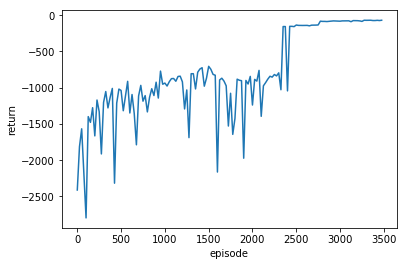

In [51]:
returns = list(map(lambda x: sum(x[2]), movie_array))
episode = list(map(lambda x: x[-1], movie_array))
plt.plot(episode, returns)
plt.xlabel('episode')
plt.ylabel('return')

In [11]:
# Learn by On-Policy Monte Carlo
movie_array = mc.on_policy_learning(num_iterations=5000, verbose=True, gamma=.8, epsilon=0.20, 
                                    sample_every=499, get_greedy_episode_after=3500)

In [52]:
# Make a movie!!

from matplotlib.patches import FancyArrow
# Get the number of frames and initialize the track image

track_matrix = np.copy(track.track)
track_matrix[-1, -1] = 4

# Create the figure of the track
fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=False, xlim=(0, track_matrix.shape[1] - 1), ylim=(0 ,track_matrix.shape[0] - 1))
ax.grid()
im = ax.imshow(np.flipud(track_matrix), origin='upper', interpolation='none')

# Make an info box
bbox_props = dict(boxstyle="round4,pad=0.3", fc="white", ec="b", lw=2)
info_template = 'Episode: %d \n Time: %d \n Reward: %d \n X_Velocity: %d \n Y_Velocity: %d'

# annotation
annotation = ax.annotate(
    info_template %(0, 0, 0, 0, 0),
    xy=(track_matrix.shape[0] - 2.5, .5),
    bbox=bbox_props
)
annotation.set_animated(True)


def frame_generator():
    for m_idx, m in enumerate(movie_array):
        visited_states, _, _, _, _ = m
        for vs_idx, vs in enumerate(visited_states):
            yield (m_idx, vs_idx)


def updatetrack(idx):
    m_idx, vs_idx = idx
    m = movie_array[m_idx]
    track_matrix = np.copy(track.track)
    visited_states, actions_taken, rewards_given, had_crash, episode_count = m
    state = visited_states[vs_idx]
    x, y = track.convert_cartesian_to_indexes(state[0][0], state[0][1])
    vx, vy = state[1][0], state[1][1]
    
    # place the car
    if had_crash[vs_idx]:
        track_matrix[x, y] = 3
    else:
        track_matrix[x, y] = 4

    # get rewards
    r = sum(rewards_given[:(vs_idx + 1)])
    action = actions_taken[vs_idx]
        
    # update the figure
    im.set_array(np.flipud(track_matrix))
    annotation.set_text(info_template %(episode_count, vs_idx, r, vx, vy))
    ax.patches = []
    ax.add_patch(FancyArrow(
        x=state[0][0], y=state[0][1],
        dx=action[0], dy=action[1], 
        head_length=.2, head_width=.25, width=.1, edgecolor='white'
    ))
    
    return im, annotation

anim = animation.FuncAnimation(fig, updatetrack, frames=frame_generator, blit=False, save_count=9000)
display_animation(anim)

In [174]:
from matplotlib.animation import FFMpegWriter
anim.save('racecar.mp4', fps=60, writer=FFMpegWriter())